## Packages and Parameters

In [1]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
import csv
import matplotlib.patches as patches
from scipy.integrate import simps
from scipy.optimize import minimize
from numpy import genfromtxt

C:\Users\gutierrez\AppData\Local\Temp\4\ipykernel_30776\4157251717.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
lumapi = imp.load_source("lumapi", "C:/Program Files/Lumerical/v202/api/python/lumapi.py")
MODE = lumapi.MODE("Template_Luis.lms")

In [3]:
from scipy.constants import pi, c, epsilon_0
#Basic units
pm = 1e-12
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12
pJ = 1e-12
mW = 1e-3

#Simulation Parameters
λ = 1064*nm
ωp = 2*pi*c/λ

width = 1850*nm
etch = 350*nm

h_LN = 700*nm
theta = 60

w_slab = 20*um
h_margin = 5*um
h_substrate = 5*um
meshsize = 50*nm
finemesh = 10*nm
wg_length = 10*um #Useless in MODE

In [4]:
material_substrate = "SiO2_analytic"
material_thinfilm = "LN_analytic_MgO_doped_xne"

## Util functions

In [5]:
#This gaussian defines an electric field profile, given the radius of the x and y directions wx, wy
def gaussian(xx, yy, wx, wy, xoff, yoff, test):
    #relationship between waist radius at 1/e point of electric field and the standard deviation of the gaussian
    fac = np.sqrt(2)/2
    
    #Define X gaussian 
    xsd = wx*fac  
    xgaus = np.exp(-(xx-xoff)**2/(2*xsd**2))

    #Define Y gaussian 
    ysd = wy*fac 
    ygaus = np.exp(-(yy-yoff)**2/(2*ysd**2)) 
    
    #Calculate 2D gaussian
    xx, yy = np.meshgrid(xx,yy) 
    zgaus = np.outer(ygaus,xgaus) 
    
    if test:
        plt.rcParams["figure.figsize"] = (25,20) 
        plt.subplot() 
        plt.pcolor(xx, yy, zgaus, cmap='jet') 
        plt.axis([xx.min(), xx.max(), yy.min(), yy.max()]) 
        plt.colorbar() 
        plt.show()
        
    return zgaus

def plotmode(xx,yy,Ex):  
    xx, yy = np.meshgrid(xx,yy) 
    plt.rcParams["figure.figsize"] = (10,6) 
    plt.subplot() 
    plt.pcolor(xx, yy, Ex, cmap='jet') 
    plt.axis([xx.min(), xx.max(), yy.min(), yy.max()]) 
    plt.colorbar()  
    plt.show()
    
    return

def overlap(ExWG,ExIn,x,y):
    Ext = np.transpose(ExWG)

    numIntegrand = np.conjugate(Ext)*ExIn
    denIntegrandWG = np.absolute(Ext)**2
    denIntegrandMODE = np.absolute(ExIn)**2

    numInt = np.absolute(simps(simps(numIntegrand, x), y))**2
    denIntMODE = simps(simps(denIntegrandMODE, x), y)
    denIntWG = simps(simps(denIntegrandWG, x), y)

    overlap = numInt / (denIntMODE*denIntWG)
    return overlap

def overlapMIN(args):
    wx,wy,yoff = args[0],args[1],args[2]
    
    xoff = 0
    ExIn = gaussian(x, y, wx, wy, xoff, yoff, 0)
    ExWG = Ex
    
    Ext = np.transpose(ExWG)

    numIntegrand = np.conjugate(Ext)*ExIn
    denIntegrandWG = np.absolute(Ext)**2
    denIntegrandMODE = np.absolute(ExIn)**2

    numInt = np.absolute(simps(simps(numIntegrand, x), y))**2
    denIntMODE = simps(simps(denIntegrandMODE, x), y)
    denIntWG = simps(simps(denIntegrandWG, x), y)

    overlap = numInt / (denIntMODE*denIntWG)
    return (1-overlap)

def getWGMode():
    #Derived parameters
    h_slab = h_LN - etch
    width_base = width + 2*etch/np.tan(theta*pi/180)
    w_sidewall = etch/np.tan(theta*pi/180)
    #print('Width at the base = %.3f um' %( width_base/um ) )
    #print('Slab thickness = %.3f um' %(h_slab/um) )

    #Draw waveguide and solver
    MODE.switchtolayout()
    lum.draw_wg(MODE, material_thinfilm, material_substrate,
          h_LN, h_substrate, etch, width, w_slab, theta, wg_length)
    lum.add_fine_mesh(MODE, finemesh, h_LN, width_base, x_factor=1.2, y_factor=1.5)
    lum.add_2D_mode_solver(MODE, meshsize, h_LN, h_substrate, 
                     w_slab, wg_length, h_margin)

    #Get mode
    _neff, _ng, _loss, _te = lum.solve_mode(MODE, λ, nmodes=6)
    for km in range(_neff.size): #Look for first TE mode
        if _te[km]>0.9:
            M = lum.mode()
            M.get_from_lumerical(MODE, km+1)
            neff_pump = _neff[km]
            break
    return M

def getWGModeAtWidth(newWidth):
    #Derived parameters
    h_slab = h_LN - etch
    width_base = width + 2*etch/np.tan(theta*pi/180)
    w_sidewall = etch/np.tan(theta*pi/180)
    #print('Width at the base = %.3f um' %( width_base/um ) )
    #print('Slab thickness = %.3f um' %(h_slab/um) )

    #Draw waveguide and solver
    MODE.switchtolayout()
    lum.draw_wg(MODE, material_thinfilm, material_substrate,
          h_LN, h_substrate, etch, newWidth, w_slab, theta, wg_length)
    lum.add_fine_mesh(MODE, finemesh, h_LN, width_base, x_factor=1.2, y_factor=1.5)
    lum.add_2D_mode_solver(MODE, meshsize, h_LN, h_substrate, 
                     w_slab, wg_length, h_margin)
    
    #Get mode
    _neff, _ng, _loss, _te = lum.solve_mode(MODE, λ, nmodes=15)
    for km in range(_neff.size): #Look for first TE mode
        if _te[km]>0.9:
            M = lum.mode()
            M.get_from_lumerical(MODE, km+1)
            neff_pump = _neff[km]
            break
    return M

# Enter wstart and wend in um. 
def compareOverlaps(wstart, wend, numGaussian):   
    modeSpace = np.linspace(wstart,wend,numGaussian)

    #This is the roughly optimized gaussian offset for our waveguide eigenmode. 
    xoff = 0
    yoff = 0.328861*um
     
    MODE.switchtolayout()
    MODE.set("use fully vectorial thin lens beam profile", 0)
    for i,w in enumerate(modeSpace):
        MODE.set('waist radius', w*um)
        newGauss = MODE.createbeam()
        
    print("Gaussians Created in Lumerical...")

    M = getWGMode()
    x = M.E.xx
    y = M.E.yy
    ExWG = M.E.x
    
    print("Waveguide Eigenmode Calculated in Lumerical...")
    
    lumOverlap = [0] * len(modeSpace) 
    for i,w in enumerate(modeSpace):
        name = ('gaussian' + str(i+1))
        lumOverlap[i] = MODE.overlap("mode3",name,0,yoff,0)[0][0]
        
    print("Lumerical Overlap Calculations performed...")
    
    #Calculate Gaussians and Overlap with 
    myOverlap = [0] * len(modeSpace) 
    for i,w in enumerate(modeSpace):
        wx = w*um
        wy = w*um
        ExIn = gaussian(x,y,wx,wy,xoff,yoff,0)
        myOverlap[i] = overlap(ExWG,ExIn,x,y); 
    print("Gaussians Created and Overlap Calculations performed using this code...")

    plt.plot(modeSpace, myOverlap, label = "Ben")
    plt.plot(modeSpace, lumOverlap, label = "Lumerical")
    plt.rcParams["figure.figsize"] = (10,5) 
    plt.legend()
    plt.xlabel("Gaussian Beam Waist [um]")
    plt.ylabel("Mode Overlap")
    plt.show()
    return 

#This is the function being optimized by 'findWGModeWidth()'
def overlapAtWidth(wx):
    wyFromFit = 0.0000006693728841;
    wxGauss = np.transpose(gaussian(x,y,wx,wy_avg,0,0,0))
    return 1-overlap(wxGauss,Elaser,x,y)

# This function optimizes a gaussian x direction with fixed height and offset.
# The fixed height and offset come from 
def findWGModeWidth():
    wxi = 5*um
    return minimize(overlapAtWidth,wxi,method='Nelder-Mead').x[0]

#Good for 3um to 11um WG beam waist
def fitWx(ex):
    return const[0]*ex+const[1]

#This is the function being optimized by 'findWGModeWidth()'
def overlapAtYoff(yoff):
    wxGauss = gaussian(x,y,wxo,wy_avg,0,yoff,0)
    return 1-overlap(Ex,wxGauss,x,y)

# This function optimizes a gaussian x direction with fixed height and offset.
# The fixed height and offset come from 
def findWGModeYoff():
    yoffi = 0.35*um
    return minimize(overlapAtYoff,yoffi,method='Nelder-Mead').x[0]

#This is the function being optimized by 'findWGModeWidth()'
def overlapAtYoff2(yoff):
    wxGauss = gaussian(x,y,wxl,wyl,0,yoff,0)
    return 1-overlap(Ex,wxGauss,x,y)

# This function optimizes a gaussian x direction with fixed height and offset.
# The fixed height and offset come from 
def findWGModeYoff2():
    yoffi = 0.35*um
    return minimize(overlapAtYoff2,yoffi,method='Nelder-Mead').x[0]

# Loop Used for capturing raw data.
    This takes a long time to run and needs to be run for each LN wafer thickness, etchdepth, and edge angle. 

In [6]:
# Scan from 1um to 15um get fundamental TE for each
# Optimize a gaussian, for each mode, save its WG Width, overlap with gaussian, wx, wy and yoff of gaussian)

WGwidths = np.linspace(1*um,15*um,136)
fittingData = [0] * len(WGwidths) 

for i,w in enumerate(WGwidths):
    Md = getWGModeAtWidth(w)
    Ex = Md.E.x
    x = Md.E.xx
    y = Md.E.yy
    # args are initial guess for gaussian optimization
    args = [4*um,0.35*um,0.33*um]
    # Returns a gaussian that has the best overlap with a waveguide mode
    opp = minimize(overlapMIN,args,method='Nelder-Mead')
    fittingData[i] = opp.x
    fittingData[i] = np.append(fittingData[i],w)
    fittingData[i] = np.append(fittingData[i],(1-opp.fun)*100)


C:\Users\gutierrez\AppData\Local\Temp\4\ipykernel_30776\1369121113.py:70: RuntimeWarning: invalid value encountered in double_scalars
  overlap = numInt / (denIntMODE*denIntWG)


## Raw data generated for the parameters height=700nm, Etch=350nm, Theta=60deg

In [18]:
# here is the raw data from the above
xyMesh = genfromtxt('xyMeshH700E350T60.csv', delimiter=',')
xMesh = np.transpose(xyMesh)
yMesh = np.transpose(xyMesh[0:318])
x = xMesh[0]
y = yMesh[1]

raw = genfromtxt('WGModeDataH700E350T60_8_19.csv', delimiter=',')
raw = np.transpose(raw[1:131])

wx = raw[0]
wy = raw[1]
yoff = raw[2]
wg_widths = raw[3]
ovlp = raw[4]

# This fit is used to find the correct wg width from the estimated optimal wg mode x-waist
const = np.polyfit(wx, wg_widths, 1)
fit = const[0]*wx+const[1]

wy_avg = np.mean(wy)

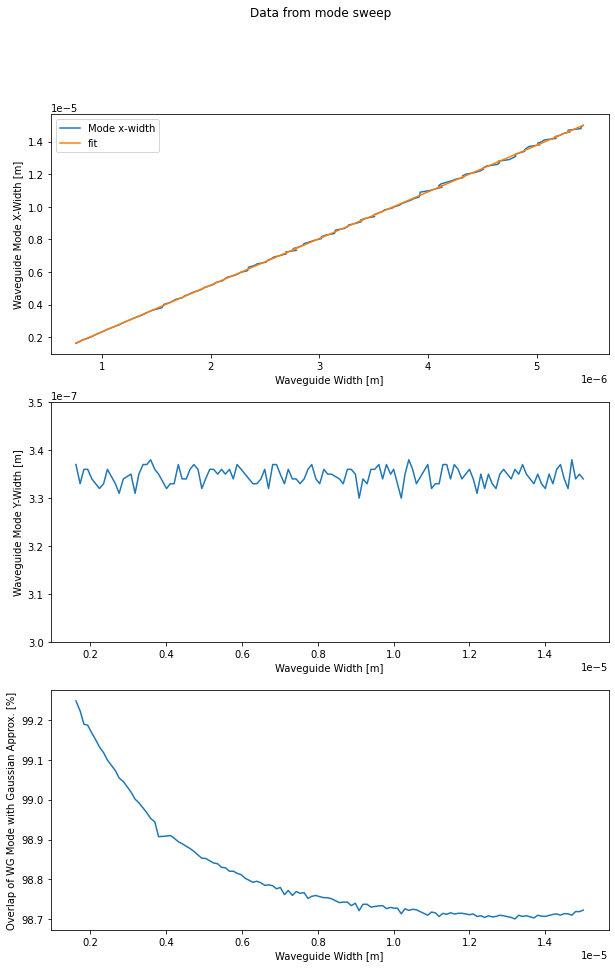

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Data from mode sweep')
ax1.plot(wx, wg_widths, label = "Mode x-width")
ax1.plot(wx, fit, label = "fit")
ax1.legend()
ax1.set_xlabel("Waveguide Width [m]")
ax1.set_ylabel("Waveguide Mode X-Width [m]")

ax2.plot(wg_widths, wy, label = "wy")
ax2.set_ylim(3e-7, 3.5e-7)
ax2.set_xlabel("Waveguide Width [m]")
ax2.set_ylabel("Waveguide Mode Y-Width [m]")

ax3.plot(wg_widths, ovlp, label = "Overlap")
ax3.set_xlabel("Waveguide Width [m]")
ax3.set_ylabel("Overlap of WG Mode with Gaussian Approx. [%]")


plt.rcParams["figure.figsize"] = (10,15) 
plt.show()

# Here is the algorithm for finding optimal wg width

In [9]:
# Input of Laser beam waist dimensions
wxl = 7.6*um 
wyl = 1.62*um

# Create a gaussian Ex-field of the laser (Fundamental TE)
Elaser = gaussian(x,y,wxl,wyl,0,0,0)

# Using this laser Ex-Gaussian, optimize the overlap for our WG Mode. Return the x direction beam waist of WG mode.
wxo = findWGModeWidth()

# With this dimension, use the fit to find the proper WG width:
wgx = fitWx(wxo)

# plot the optimized mode and the laser mode, output the overlap
ExWG = gaussian(x,y,wxo,wy_avg,0,0,0)
ExWGt = np.transpose(ExWG)
overlap(ExWGt,Elaser,x,y)

0.7057974701318794

## To check, we can get the WG mode from lumerical and overlap with the laser input

In [17]:
M = getWGModeAtWidth(wgx)
Ex = M.E.x

In [19]:
x = M.E.xx
y = M.E.yy

In [20]:
yoff_opt = findWGModeYoff()
Elaser = gaussian(x,y,wxl,wyl,0,yoff_opt,0)
ExWG = gaussian(x,y,wxo,wy_avg,0,yoff_opt,0)

yoff_opt

3.36875e-07

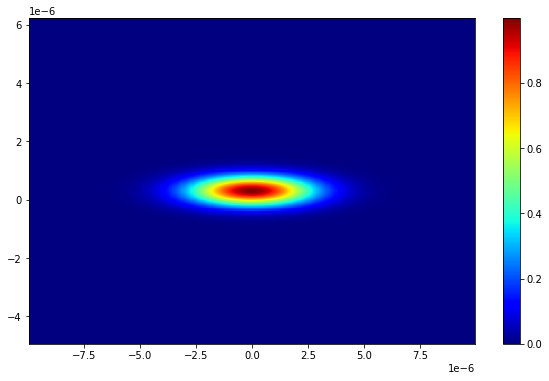

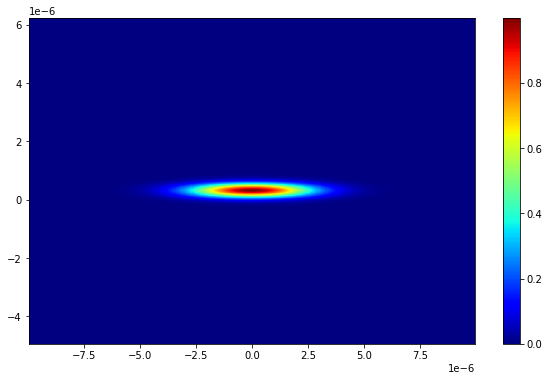

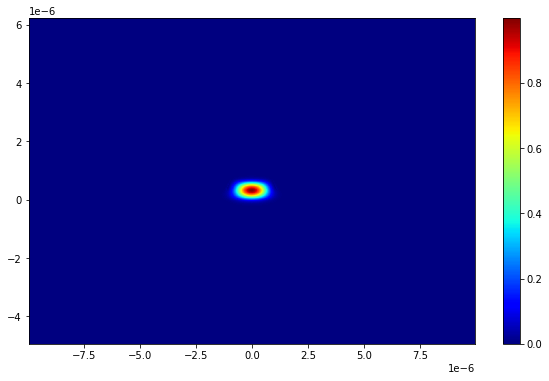

30.90984088763574

In [28]:
plotmode(x,y,np.absolute(Elaser)**2)
plotmode(x,y,np.absolute(ExWG)**2)
plotmode(x,y,np.transpose(np.absolute(Ex)**2))
overlap(Ex,Elaser,x,y)*100

# Comparison of Circular Gaussian Beams from Lumerical to My code

Gaussians Created in Lumerical...
Waveguide Eigenmode Calculated in Lumerical...
Lumerical Overlap Calculations performed...
Gaussians Created and Overlap Calculations performed using this code...


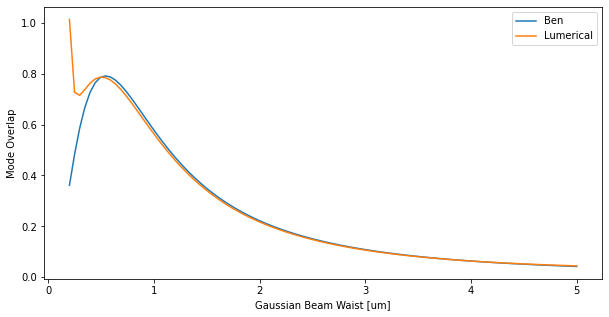

In [10]:
# Create 100 Gaussians spanning 0.3um to 10um beam waist Radius!. Compare Lumericals overlap with my overlap functions.
compareOverlaps(0.2,5,100)

In [ ]:
# Agreement is good between 0.5um and 10um
# Below 0.5um, results begin to diverge a bit.

## Get Waveguide Mode Coordinate system

In [ ]:
#Get the mode
M = getWGMode()

#This is the "mode"
M 

#This is the electric field of the mode
M.E 

#These are the components of the electric field
Ex = M.E.x
Ey = M.E.y
Ez = M.E.z

#These are the x and y coordinates of the grid. You need to calculate the Gaussian beam over these coordinates
x = M.E.xx
y = M.E.yy

## Retreiving mode data from Lumerical

In [ ]:
np.squeeze(MODE.getdata('FDE::data::gaussian1', 'Ex'))

# What is the overlap before the optimization?

In [25]:
# Input of Laser beam waist dimensions
wxl = 7.61*um 
wyl = 1.62*um

# Create a gaussian Ex-field of the laser (Fundamental TE)
Elaser = gaussian(x,y,wxl,wyl,0,0,0)
M = getWGMode()

#These are the components of the electric field
Ex = M.E.x
Ey = M.E.y
Ez = M.E.z

#These are the x and y coordinates of the grid. You need to calculate the Gaussian beam over these coordinates
x = M.E.xx
y = M.E.yy

yoff_opt = findWGModeYoff2()
Elaser = gaussian(x,y,wxl,wyl,0,yoff_opt,0)

overlap(Ex,Elaser,x,y)

0.30909840887635737

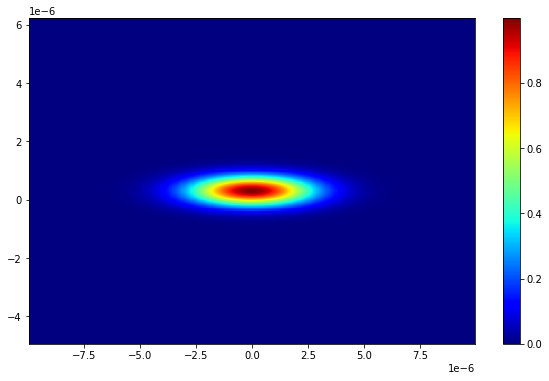

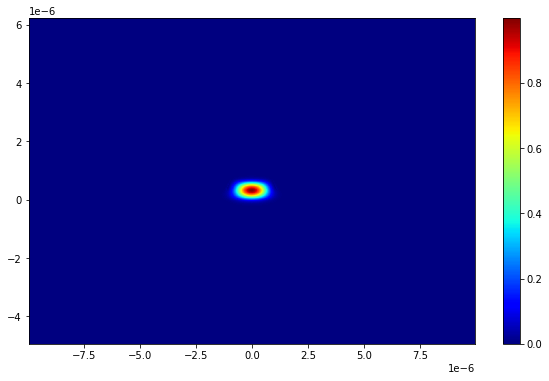

In [27]:
plotmode(x,y,np.absolute(Elaser)**2)
plotmode(x,y,np.transpose(np.absolute(Ex)**2))